In [33]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import torch
import shap

from typing import List

import pickle as pkl
import matplotlib.gridspec as gridspec
from dataset import Dataset, obtain_accord_baselines, obtain_unnorm_accord_baselines
from functools import reduce

from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics
from captum.attr import (
    DeepLift,
    FeatureAblation,
    FeaturePermutation,
    IntegratedGradients,
    KernelShap,
    Lime,
    ShapleyValueSampling,
    GradientShap,
)
module_path = os.path.abspath(os.path.join('CATENets/'))

if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as pseudo_outcome_nets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def plot_feature_values(feature_values, x_test, feature_names):

    feature_num = feature_values.shape[1]
    ind = np.argpartition(np.abs(feature_values).mean(0), -feature_num)[-feature_num:]
    
    feature_names = [
        a + ": " + str(b) for a,b in zip(np.array(feature_names)[ind], np.abs(feature_values[:, ind]).mean(0).round(4))
    ]

    shap.summary_plot(
        feature_values[:, ind],
        x_test[:, ind], 
        feature_names=feature_names,
        show=False
    )
    
    
    fig, ax = plt.gcf(), plt.gca()
    plt.gcf().axes[-1].set_aspect(100)
    
    # Modifying main plot parameters
    ax.tick_params(labelsize=12)
    
    ax.set_xlabel("", fontsize=8)
    ax.set_title('ACCORD - Shapley Value', fontsize=14)
    
    # Add custom text to the x-axis
    ax.text(-0.1, -2.5, "Intensive Tx worse", color="black", ha="center", fontsize=15)  # replace 0.2 and -1 with your preferred coordinates
    ax.text(0.1, -2.5, "Intensive Tx better", color="black", ha="center", fontsize=15)  # replace 0.8 and -1 with your preferred coordinates

    # Get colorbar
    cb_ax = fig.axes[1] 
    
    # Modifying color bar parameters
    cb_ax.tick_params(labelsize=10)
    cb_ax.set_ylabel("Feature value", fontsize=15)

    plt.show()

In [46]:
blood_pressure = pd.read_csv("data/accord/bloodpressure.csv")
accord_key = pd.read_csv("data/accord/accord_key.csv")
meds = pd.read_csv("data/accord/concomitantmeds.csv")
labs = pd.read_csv("data/accord/otherlabs.csv")
lipids = pd.read_csv("data/accord/lipids.csv")
hba1c = pd.read_csv("data/accord/hba1c.csv")
cvdoutcomes = pd.read_csv("data/accord/cvdoutcomes.csv")
activity = pd.read_csv("data/accord/activitystatus.csv")
history = pd.read_csv("data/accord/inclusionexclusionsummary.csv")
pe = pd.read_csv("data/accord/baselinehistoryphysicalexam.csv")

In [47]:
## Preprocessing medications 

pe["bmi"] = pe["wt_kg"]/((pe["ht_cm"]/100)**2)

meds.rename(columns={"potassium":"potassium_oral"}, inplace=True)
dm_meds = [
       'la_insulin', 'othbol_insulin', 'premix_insulin', 'other_diabmed',
       'nphl_insulin', 'meglitinide', 'ag_inhibitor', 'reg_insulin',  'tzd'
        , 'sulfonylurea', 'biguanide'
]

bp_meds = [
        'a2rb', 'acei', 'dhp_ccb', 'nondhp_ccb', 'alpha_blocker', 'central_agent',
        'beta_blocker', 'vasodilator', 'reserpine', 'other_bpmed',
]

cv_meds = [
        'digitalis', 'nitrate', 'other_cvmed',  
]

lipid_meds = [
        'fibrate', 'other_lipidmed', 'cholest_abi'
]

# TBD
# 'loop', 'thiazide', 'ksparing', 'potassium_oral', 
# 'anti_inflam','bile_sequestrant',
# 'cox2', 'thyroid', 'progestin', 'estrogen', 'oral_asthma',
# 'anti_depress', 'inhaled_asthma', 'oral_steroid', 'anti_psych',
# 'osteoporosis', 'fluid_retention', 'other_med', 'vitamin', 'otc',
# 'herbal'

totalmeds = [
            'a2rb', 'acei', 'dhp_ccb', 'nondhp_ccb', 'alpha_blocker', 'central_agent',
        'beta_blocker', 'vasodilator', 'reserpine', 'other_bpmed',
            'digitalis', 'nitrate', 'other_cvmed',  
        'fibrate', 'other_lipidmed', 'cholest_abi',
       'la_insulin', 'othbol_insulin', 'premix_insulin', 'other_diabmed',
       'nphl_insulin', 'meglitinide', 'ag_inhibitor', 'reg_insulin',  'tzd'
        , 'sulfonylurea', 'biguanide',
            'loop', 'thiazide', 'ksparing', 'potassium_oral', 
        'anti_inflam','bile_sequestrant',
        'cox2', 'thyroid', 'progestin', 'estrogen', 'oral_asthma',
        'anti_depress', 'inhaled_asthma', 'oral_steroid', 'anti_psych',
        'osteoporosis', 'other_med', 
     # 'fluid_retention',
    # 'vitamin', 'otc',
        # 'herbal'
]

# Create new columns based on the presence of medications in the categories
meds['dm_med'] = meds[dm_meds].sum(axis=1)
meds['bp_med'] = meds[bp_meds].sum(axis=1)
meds['cv_med'] = meds[cv_meds].sum(axis=1)
meds['lipid_med'] = meds[lipid_meds].sum(axis=1)
# meds["nagents"] = meds[totalmeds].sum(axis=1)


In [48]:

dfs = [
    cvdoutcomes[["MaskID", "censor_po"]],
    history[["MaskID","x4smoke"]],
    pe[["MaskID", "bmi"]],
    accord_key[accord_key.treatment.str.contains("BP")][["MaskID", "female", "baseline_age", "treatment", "cvd_hx_baseline", "raceclass"]],
    lipids[lipids.Visit == "BLR"].drop(columns="Visit"),
    labs[labs.Visit == "BLR"].drop(columns="Visit"),
    blood_pressure[blood_pressure.Visit == "BLR"].drop(columns="Visit"),
    meds[meds.Visit == "BLR"].drop(columns="Visit")
]

# Merge all dataframes using reduce
data = reduce(lambda left, right: pd.merge(left, right, on="MaskID", how="inner"), dfs)

# data.to_csv("accord.csv")

In [49]:
outcome = "censor_po"
treatment = "treatment"

continuous_vars = [
    'baseline_age', 
    'bmi',
    'sbp', 'dbp','hr',
    'fpg', 'alt', 'cpk',
    'potassium', 'screat', 'gfr',
    'ualb', 'ucreat', 'uacr',
    'chol', 'trig','vldl', 'ldl','hdl'

]


binary_vars = [
    'female',
    'cvd_hx_baseline',
    # 'cvdhist',
    'statin',
    'aspirin',
    'antiarrhythmic',
    'anti_coag',
    'dm_med',
    'bp_med',
    'cv_med',
    'lipid_med',
    'x4smoke'
]

cate_vars = [
    # 'raceclass'
]

data["raceclass"] = np.where(data["raceclass"]=="Black", 1, 0)
data["treatment"] = np.where(data["treatment"].str.contains("Intensive BP"), 1, 0)
# data["censor_po"] = np.where(data["censor_po"]==1, 0, 1)


data = data[continuous_vars + cate_vars + binary_vars + [treatment] + [outcome]]

# scaler = preprocessing.MinMaxScaler()
# data[continuous_vars] = scaler.fit_transform(data[continuous_vars])
# data = pd.get_dummies(data, columns=cate_vars)
# names = data.drop([treatment, outcome], axis=1).columns 
# print(names)

In [117]:
subgroup = data[['aspirin','fpg', 'treatment', 'censor_po']].dropna()

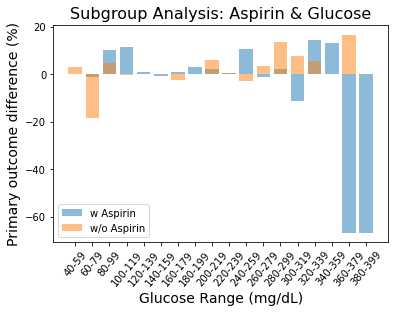

In [159]:
# Group by fpg_group, treatment, and then calculate the mean of censor_po

subgroup['fpg_group'] = (subgroup['fpg'] // 20).astype(int)
subgroup['pt_count'] = subgroup.groupby('fpg_group')['fpg_group'].transform('count')
group_counts = subgroup[['fpg_group', 'pt_count']].drop_duplicates()

grouped_with_aspirin = subgroup[subgroup['aspirin'] == 1.0].groupby(['fpg_group', 'treatment'])['censor_po'].mean().unstack()
# Calculate the absolute difference between treated and control
grouped_with_aspirin['abs_diff'] = (grouped_with_aspirin[1] - grouped_with_aspirin[0]) * 100
grouped_with_aspirin = grouped_with_aspirin.reset_index()[['fpg_group', 'abs_diff']]

# Group by fpg_group, treatment, and then calculate the mean of censor_po
grouped_without_aspirin = subgroup[subgroup['aspirin'] == 0.0].groupby(['fpg_group', 'treatment'])['censor_po'].mean().unstack()

# Calculate the absolute difference between treated and control
grouped_without_aspirin['abs_diff'] = (grouped_without_aspirin[1] - grouped_without_aspirin[0])* 100
grouped_without_aspirin = grouped_without_aspirin.reset_index()[['fpg_group', 'abs_diff']]
grouped_without_aspirin


result = pd.concat([grouped_with_aspirin.set_index('fpg_group'), 
                    grouped_without_aspirin.set_index('fpg_group').rename(columns={'abs_diff': 'abs_diff_without_aspirin'})], 
                   axis=1)

# Reset the index for the final table


result = result.reset_index()

result['fpg_range'] = result['fpg_group'].apply(lambda x: f"{x*20}-{(x+1)*20-1}")
result = result.merge(group_counts, on='fpg_group', how='left')
result = result.drop('fpg_group', axis=1)

result.dropna(inplace=True)

plt.bar(result['fpg_range'], result['abs_diff'], alpha=0.5, label="w Aspirin")
plt.bar(result['fpg_range'], result['abs_diff_without_aspirin'],alpha=0.5, label="w/o Aspirin")

plt.ylabel('Primary outcome difference (%)', size=14)
plt.xlabel("Glucose Range (mg/dL)", size=14)
plt.xticks(rotation=50)

plt.title("Subgroup Analysis: Aspirin & Glucose", size=16)
plt.legend()

In [3]:
data = Dataset("accord", 0)


In [38]:
data = Dataset("accord", 0)

x, w, y = data.get_data()

trials = 15

results = np.zeros((trials, len(x)))

# # for i in range(trials):
    
# model = pseudo_outcome_nets.XLearner(  
#     x.shape[1],
#     binary_y=(len(np.unique(y)) == 2),
#     n_layers_out=2,
#     n_units_out=100,
#     batch_size=128,
#     n_iter=1000,
#     nonlin="relu",
#     device="cpu",
#     # seed= i
# )

# model.fit(x, y, w)
# results[i] = model.predict(x).detach().cpu().numpy().reshape(-1)

0.027311129441109472 (100, 4712)
Output 0.027311129441109472: 95% CI = (-0.006, 0.062)


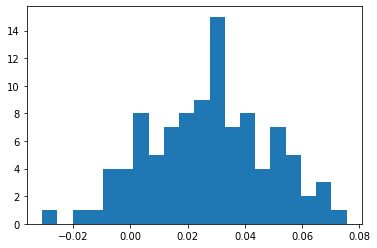

In [4]:
import pickle as pkl

predict_results  = pkl.load(open("results/accord_sprint/accord_predict_results_True.pkl", 'rb'))

mean_ates = predict_results.mean(1)

print(mean_ates.mean(0), predict_results.shape)
plt.hist(mean_ates, bins=20)

lower_bounds = np.percentile(mean_ates, 5, axis=0)
upper_bounds = np.percentile(mean_ates, 95, axis=0)

# Print the confidence intervals
print(f"Output {mean_ates.mean(0)}: 95% CI = ({lower_bounds:.3f}, {upper_bounds:.3f})")

In [10]:
adj_p = {
    'baseline_age':0.98 ,
    "female": 0.98,
    'cvd_hx_baseline':0.78,
    "fpg": 0.11,
    "raceclass": 0.44,
    "sbp": 0.99, 
    "dbp": 0.7
    # 'statin',
    # 'aspirin',
    # 'antiarrhythmic',
    # 'anti_coag',
    # 'x4smoke'
}

In [6]:
adj_p = {
    'baseline_age':0.65 ,
    "female": 0.74,
    'cvd_hx_baseline':0.04,
    "fpg": 0.03,
    "raceclass": 0.29
    # 'statin',
    # 'aspirin',
    # 'antiarrhythmic',
    # 'anti_coag',
    # 'x4smoke'
}

(4712, 26) (4712, 26)


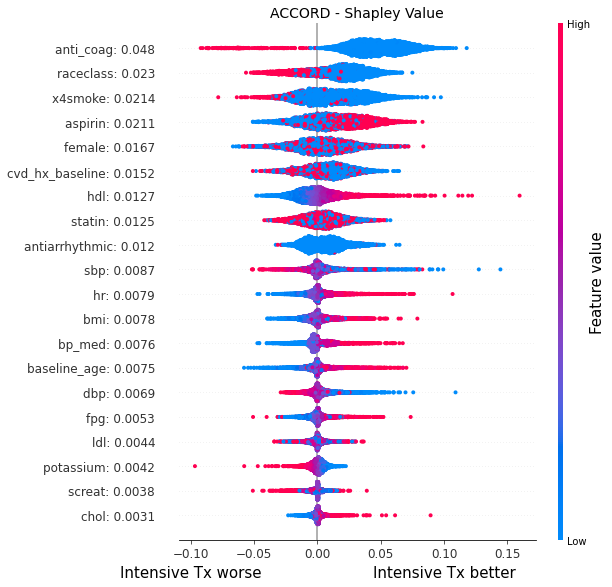

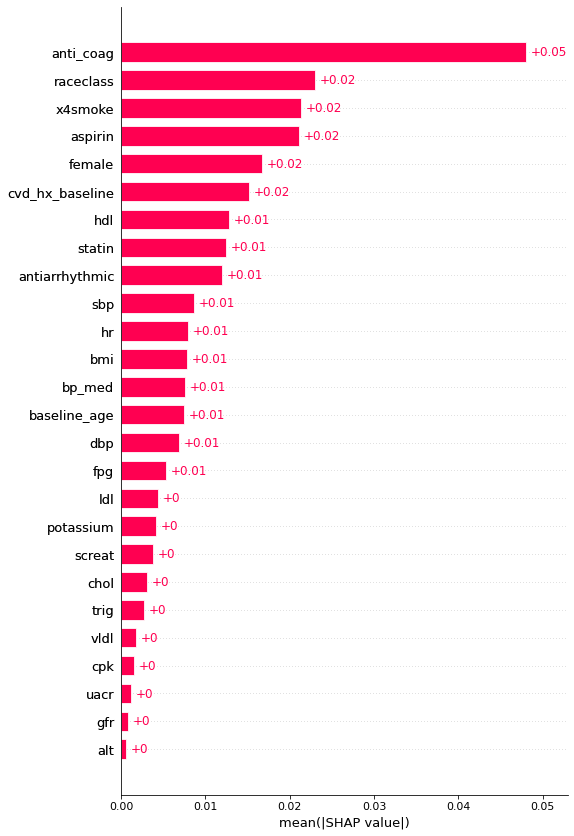

In [11]:
sprint_x, _ , _ , accord_x, _, _ = obtain_accord_baselines()
_, _ ,_ , unnorm_x , _, _ = obtain_unnorm_accord_baselines()


data = Dataset("accord", 0 )

avg_shap = pkl.load(open("results/accord/shap_bootstrapped_True.pkl",'rb'))

print(x.shape, avg_shap.mean(0).shape)

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

exp = shap.Explanation(
    avg_shap.mean(0),  
    feature_names = data.get_feature_names()
)

shap.plots.bar(
    exp,
    max_display=len(data.get_feature_names()),
)

In [13]:
from scipy import stats

shap_imp = {}

for k, _ in adj_p.items():
    feature_index = data.get_feature_names().tolist().index(k)
    shap_imp[k] = np.abs(avg_shap.mean(0)[feature_index]).mean()
        
res = stats.spearmanr(-np.log(np.array(list(adj_p.values()))), np.array(list(shap_imp.values())))
res.statistic, res.pvalue

(0.054056247761733546, 0.9083652825239955)

[2 3 4 7 6 1 5] [2 5 6 4 1 3 7]


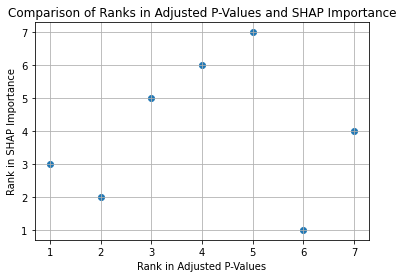

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Convert dictionary values to numpy arrays for easier manipulation
adj_p_values = -1*np.array(list(adj_p.values()))
shap_imp_values = np.array(list(shap_imp.values()))

# Calculate ranks. The '+1' makes the ranks start from 1 instead of 0.
adj_p_ranks = np.argsort(np.argsort(adj_p_values)) + 1
shap_imp_ranks = np.argsort(np.argsort(shap_imp_values)) + 1


print(adj_p_ranks, shap_imp_ranks)
# Plotting the ranks against each other
plt.scatter(adj_p_ranks, shap_imp_ranks)


plt.xlabel('Rank in Adjusted P-Values')
plt.ylabel('Rank in SHAP Importance')
plt.title('Comparison of Ranks in Adjusted P-Values and SHAP Importance')
plt.grid(True)
plt.show()

(4712, 18)


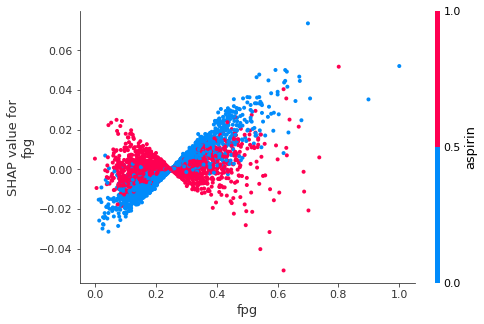

In [ ]:
print(unnorm_x.shape)
shap.dependence_plot(
    "fpg", 
     avg_shap.mean(0), 
     x, 
     feature_names=data.get_feature_names(),
     # interaction_index="cvd_hx_baseline"
)

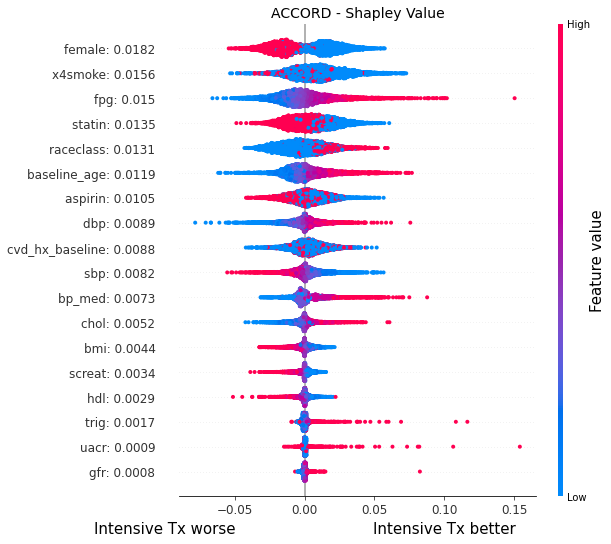

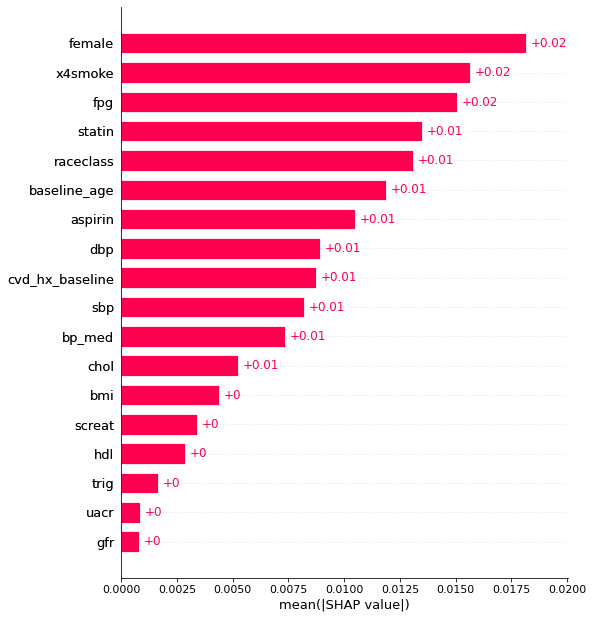

In [17]:
data = Dataset("accord_filter", 0 )

sprint_x, w , _ , accord_x,_,_ = obtain_accord_baselines()

avg_shap = pkl.load(open("results/accord_sprint/accord_shap_bootstrapped_True.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0),
    accord_x, 
    data.get_feature_names()
)

exp = shap.Explanation(
    avg_shap.mean(0),  
    feature_names = data.get_feature_names()
)

shap.plots.bar(
    exp,
    max_display=len(data.get_feature_names()),
)


In [179]:
import numpy as np
from scipy.stats import spearmanr


avg_shap_sprint = pkl.load(open("results/sprint/shap_bootstrapped_True.pkl",'rb'))
avg_shap_accord = pkl.load(open("results/accord/shap_bootstrapped_True.pkl",'rb'))

_ , n_sprint, d_sprint = avg_shap_sprint.shape
_ , n_accord, d_accord = avg_shap_accord.shape

accord = Dataset("accord_filter", 0)
sprint = Dataset("sprint_filter", 0)

print(avg_shap_sprint.shape, avg_shap_accord.shape)

sprint_features = sprint.get_feature_names().tolist()
accord_features = accord.get_feature_names().tolist()

ensemble_sprint_shap = avg_shap_sprint.reshape(-1, 5, n_sprint, d_sprint).mean(axis=1)
ensemble_accord_shap = avg_shap_accord.reshape(-1, 5, n_accord, d_accord).mean(axis=1)

ensemble_sprint_shap = np.abs(ensemble_sprint_shap).mean(1)
ensemble_accord_shap = np.abs(ensemble_accord_shap).mean(1)

def get_trial_pairs_and_cosine_values(sprint_shap_values, accord_shap_values,  prefix=''):
    trial_pairs = []
    cosine_values = []

    for i in range(accord_shap_values.shape[0]):
        for j in range(sprint_shap_values.shape[0]):

            correlation_coefficient, p_value = spearmanr(
                sprint_shap_values[i], 
                accord_shap_values[j]
            )
            cosine_values.append(correlation_coefficient)
                
    return cosine_values

rank_correlation = get_trial_pairs_and_cosine_values(ensemble_sprint_shap, ensemble_accord_shap)


(200, 9361, 19) (200, 4712, 26)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 19 and the array at index 1 has size 26

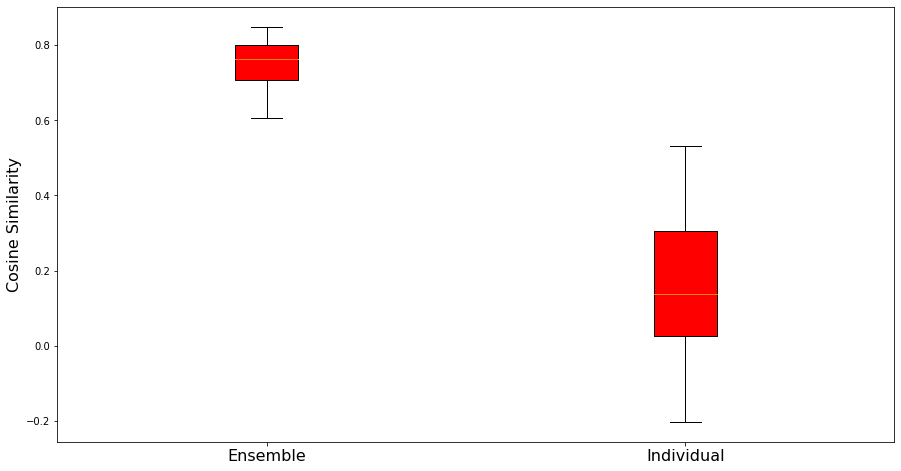

In [36]:

def get_trial_pairs_and_cosine_values(cosine_sim, prefix=''):
    trial_pairs = []
    cosine_values = []
    for i in range(cosine_sim.shape[0]):
        for j in range(cosine_sim.shape[1]):
            if i < j:
                trial_pairs.append(f"{prefix}{i}-{j}")
                cosine_values.append(cosine_sim[i, j])
    return trial_pairs, cosine_values

np.random.shuffle(avg_shap)
t, n, d = avg_shap.shape
ensemble_shap = avg_shap.reshape(-1, 20, n, d).mean(axis=1)

# Compute cosine similarities
cosine_sim_ensemble = cosine_similarity(ensemble_shap.reshape(ensemble_shap.shape[0], -1))
cosine_sim_individual = cosine_similarity(avg_shap[:10, :, :].reshape(10, -1))

trial_pairs_ensemble, cosine_values_ensemble = get_trial_pairs_and_cosine_values(cosine_sim_ensemble, 'E')
trial_pairs_individual, cosine_values_individual = get_trial_pairs_and_cosine_values(cosine_sim_individual, 'I')
# Generating random example data

# Create a figure and axis
fig, ax = plt.subplots(figsize=(5, 8))

# Ensemble data on left
x_ensemble = np.ones(len(trial_pairs_ensemble))
ax.boxplot(cosine_values_ensemble, positions=[1], patch_artist=True, boxprops=dict(facecolor="red"), labels=["Ensemble"])

# Individual data on right, offset by the number of ensemble points
x_individual = np.ones(len(trial_pairs_individual)) + 1
ax.boxplot(cosine_values_individual, positions=[2], patch_artist=True, boxprops=dict(facecolor="red"), labels=["Individual"])

# General settings
ax.set_xticklabels(['Ensemble', 'Individual'], fontsize=16)
plt.ylabel("Cosine Similarity", fontsize=16)
plt.show()

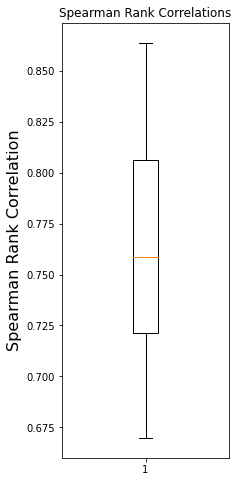

In [30]:
plt.figure(figsize=(3,8))
# plt.scatter( [i/1000 for i in range(len(rank_correlation))],rank_correlation)

plt.boxplot(rank_correlation)
plt.ylabel('Spearman Rank Correlation', size=16)
plt.title('Spearman Rank Correlations' )
plt.show()


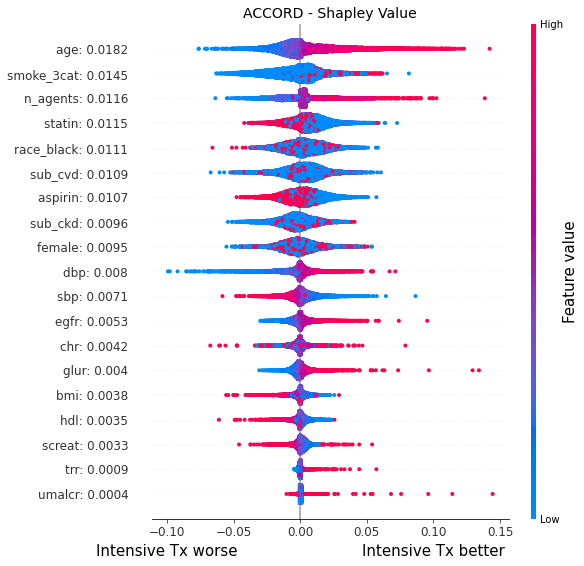

Index(['age', 'sbp', 'dbp', 'n_agents', 'egfr', 'screat', 'chr', 'glur', 'hdl',
       'trr', 'umalcr', 'bmi', 'female', 'race_black', 'smoke_3cat', 'aspirin',
       'statin', 'sub_cvd', 'sub_ckd'],
      dtype='object')

In [25]:
data = Dataset("sprint", 0 )

x, w , y = data.get_data()

gender_index = data.get_feature_names().tolist().index('female')

avg_shap = pkl.load(open("results/sprint/shap_bootstrapped_True.pkl",'rb'))

plot_feature_values(
    avg_shap.mean(0),
    x, 
    data.get_feature_names()
)

data.get_feature_names()

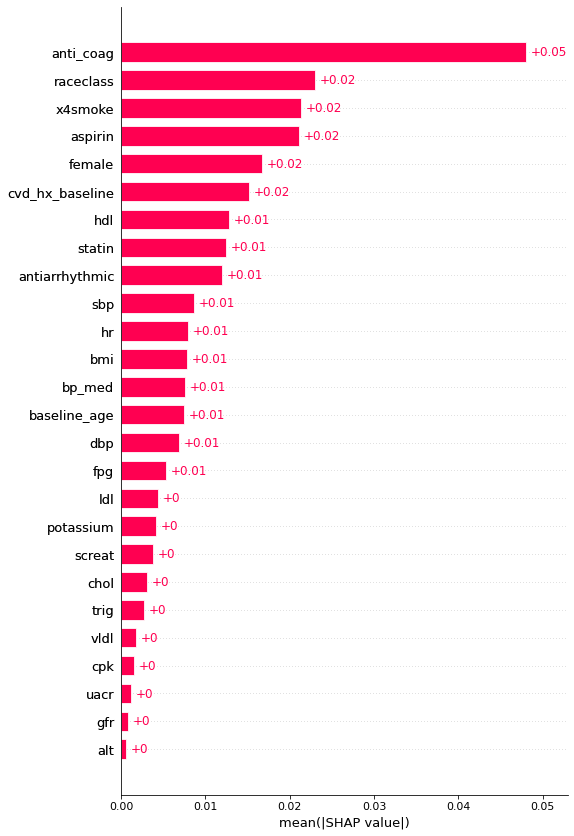

In [20]:
exp = shap.Explanation(
    avg_shap.mean(0),  
    feature_names = data.get_feature_names()
)

shap.plots.bar(
    exp,
    max_display=len(data.get_feature_names()),
)


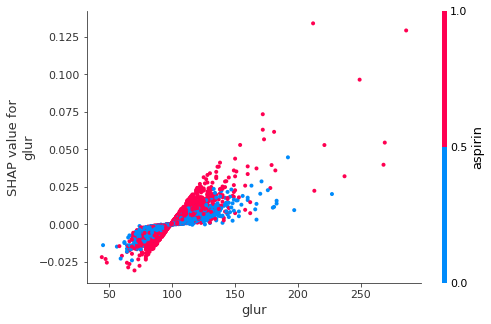

In [32]:
x_raw_con = data.get_unnorm_value(x)

x_raw = np.concatenate([x_raw_con, x[:, x_raw_con.shape[1]:]], axis=1)

shap.dependence_plot(
    "glur", 
     avg_shap.mean(0), 
     x_raw, 
     feature_names=data.get_feature_names(),
     interaction_index="aspirin"
)

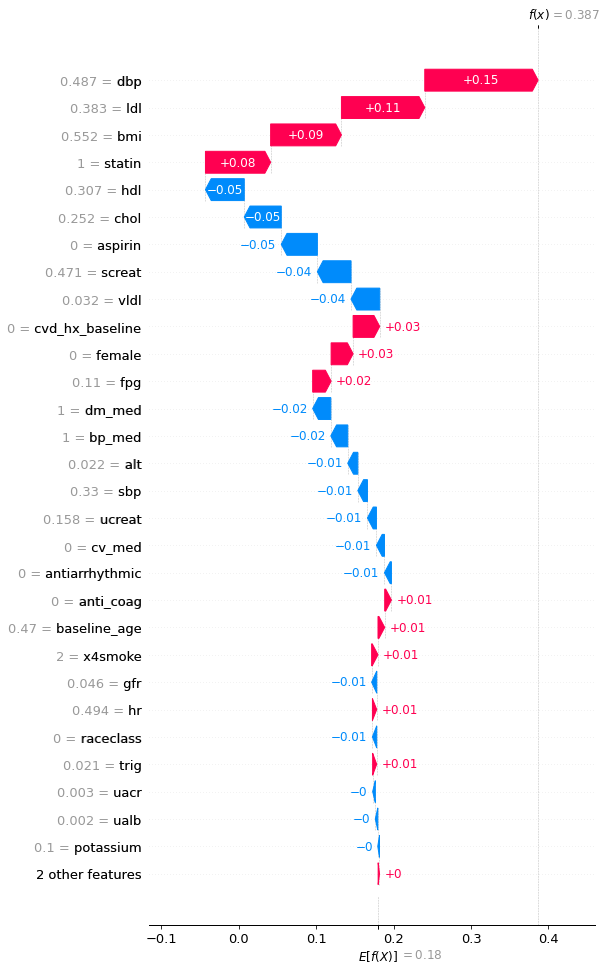

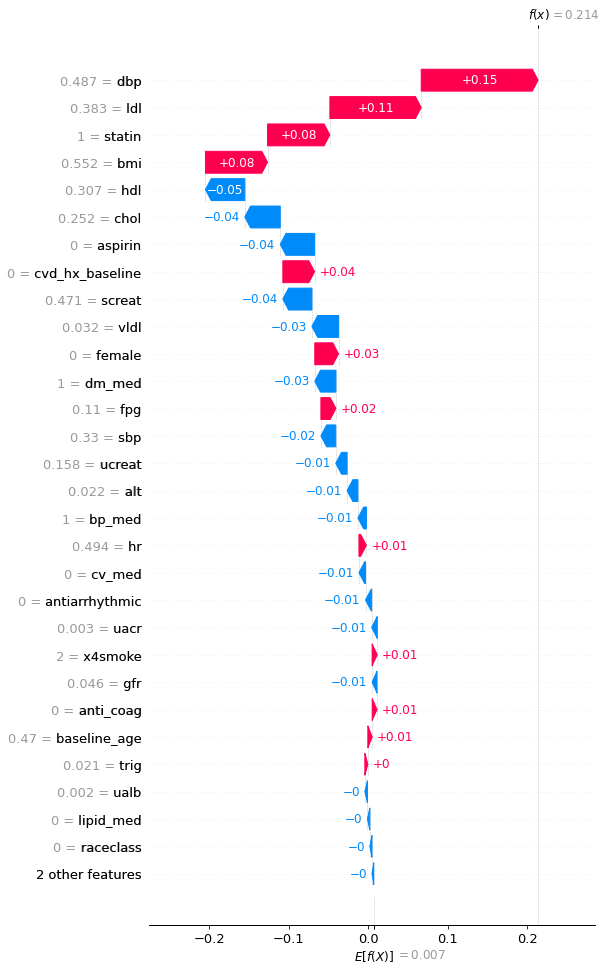

In [111]:
from shap import Explanation

import matplotlib.pyplot as plt
from PIL import Image

data = Dataset("accord", 0)

baseline_output = model.predict(x.mean(0).reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    marginal_shapley_value[1].reshape(1, -1),  
    baseline_output[0],
    data=data.get_data()[0],
    feature_names=data.get_feature_names(),
)

shap.plots.waterfall(exp[0], max_display=baseline.shape[1]) 


plt.savefig('temp_plot1.png', bbox_inches='tight')
plt.close()

baseline_output = model.predict(sprint_means.reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    sprint_shap[1].reshape(1, -1),  
    baseline_output[0],
    data=data.get_data()[0],
    feature_names=data.get_feature_names(),
)


# Create the second shap plot and save as a temporary image
shap.plots.waterfall(exp[0], max_display=baseline.shape[1])
plt.savefig('temp_plot2.png', bbox_inches='tight')
plt.close()



In [108]:
baseline_output

array([[0.18008661]], dtype=float32)

In [106]:
baseline_output

array([[0.00712857]], dtype=float32)

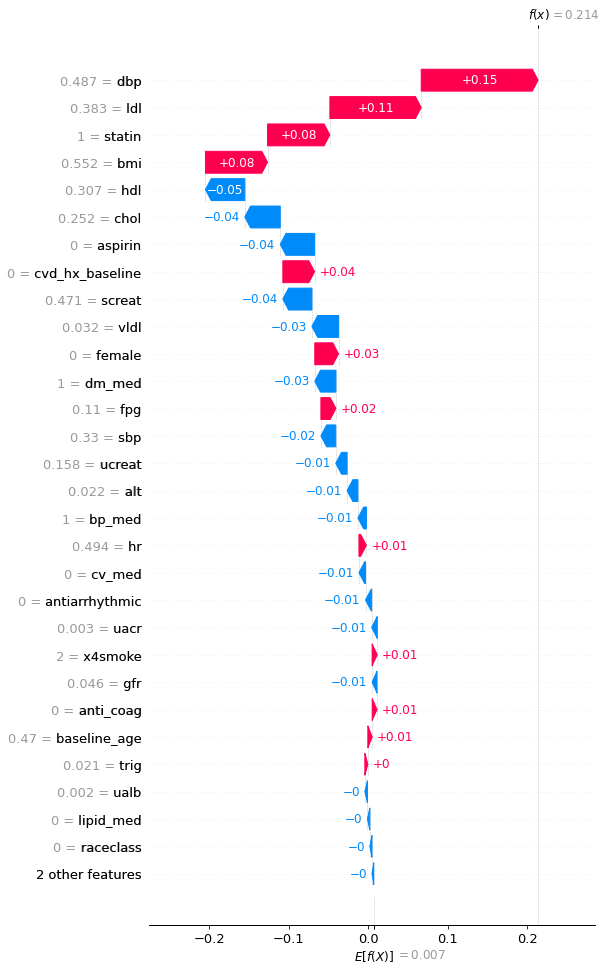

In [105]:
baseline_output = model.predict(sprint_means.reshape(1,-1)).detach().cpu().numpy()

exp = Explanation(
    sprint_shap[1].reshape(1, -1),  
    baseline_output[0],
    data=data.get_data()[0],
    feature_names=data.get_feature_names(),
)

shap.plots.waterfall(exp[0], max_display=baseline.shape[1]) 

In [72]:
data = Dataset("sprint",0)

data.get_feature_names()

Index(['age', 'sbp', 'dbp', 'n_agents', 'egfr', 'screat', 'chr', 'glur', 'hdl',
       'trr', 'umalcr', 'bmi', 'female', 'race_black', 'smoke_3cat', 'aspirin',
       'statin', 'sub_cvd', 'sub_ckd'],
      dtype='object')

In [73]:
data.data

,age,sbp,dbp,n_agents,egfr,screat,chr,glur,hdl,trr,...,bmi,female,race_black,smoke_3cat,aspirin,statin,sub_cvd,sub_ckd,intensive,event_primary
0,0.285714,0.459119,0.425532,0.333333,0.309159,0.190608,0.228883,0.152893,0.131944,0.020802,...,0.346973,0,0,1,1.0,1.0,1,0,0,1
1,0.642857,0.415094,0.329787,0.166667,0.268058,0.207182,0.468665,0.260331,0.305556,0.049744,...,0.270478,0,0,0,1.0,1.0,0,0,0,1
2,0.190476,0.452830,0.468085,0.500000,0.410599,0.080110,0.438692,0.210744,0.250000,0.048236,...,0.199690,1,0,0,0.0,1.0,0,0,1,1
3,0.333333,0.446541,0.553191,0.333333,0.313531,0.185083,0.297003,0.297521,0.208333,0.030751,...,0.356424,0,0,0,0.0,0.0,0,0,1,1
4,0.642857,0.320755,0.297872,0.333333,0.333936,0.099448,0.444142,0.202479,0.500000,0.025927,...,0.279348,1,0,0,0.0,0.0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9356,0.714286,0.415094,0.202128,0.333333,0.378418,0.080110,0.348774,0.190083,0.472222,0.015375,...,0.240833,1,0,0,1.0,1.0,0,0,0,1
9357,0.880952,0.295597,0.351064,0.500000,0.046289,0.458564,0.201635,0.161157,0.243056,0.021706,...,0.509474,1,0,0,0.0,1.0,0,1,0,1
9358,0.428571,0.408805,0.372340,0.000000,0.350259,0.160221,0.261580,0.148760,0.201389,0.015677,...,0.102543,0,0,0,0.0,1.0,1,0,0,1
9359,0.190476,0.515723,0.563830,0.000000,0.102956,0.337017,0.474114,0.243802,0.138889,0.104311,...,0.391090,1,0,0,1.0,0.0,0,1,1,1


In [71]:
x, w, y = data.get_data()

data.get_feature_range(3)

AttributeError: 'DataFrame' object has no attribute 'get_data'

# Create baseline from SPRINT

In [95]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_means_to_df2_scale(df2, df1):
    
    # Mapping of the second dataset columns to the first dataset columns
    
    mapping = {
        'baseline_age': 'age',
        'sbp': 'sbp',
        'dbp': 'dbp',
        'gfr': 'egfr',
        'screat': 'screat',
        'hdl': 'hdl',
        'bmi': 'bmi',
        'female': 'female',
        'raceclass': 'race_black',
        'x4smoke': 'smoke_3cat',
        'aspirin': 'aspirin',
        'statin': 'statin',
        'bp_med': 'n_agents'
    }

    # Columns that we won't normalize but will use their original mean
    columns_no_normalize = ['female', 'race_black', 'smoke_3cat', 'aspirin', 'statin']

    # Calculate means of df2's mapped columns
    
    df2_sampled = df2.sample(n=len(df2), replace=True)

    df2_means = df2_sampled[list(mapping.keys())].mean()

    normalized_means = []

    for key, value in mapping.items():
        mean_val = df2_means[key]
        if value not in columns_no_normalize:
            # Scale the mean value of df2's column using df1's column scale
            scaler = MinMaxScaler()
            # Fit the scaler to df1's column
            scaler.fit(df1[value].values.reshape(-1, 1))
            # Transform df2's mean value
            normalized_mean = scaler.transform([[mean_val]])[0][0]
        else:
            # If column is in columns_no_normalize list, just use the raw mean
            normalized_mean = mean_val

        normalized_means.append(normalized_mean)

    # Convert to numpy array
    result_array = pd.Series(normalized_means, index=list(mapping.values())).reindex(df1.columns, fill_value=np.nan).to_numpy()
    return result_array


data = pd.read_csv("data/accord/accord.csv")

continuous_vars = [
    'baseline_age', 
    'bmi',
    'sbp', 
    'dbp',
    'hr',
    'fpg', 
    'alt', 
    'cpk',
    'potassium',
    'screat', 
    'gfr',
    'ualb', 
    'ucreat', 'uacr',
    'chol', 'trig','vldl', 'ldl','hdl'
]

binary_vars = [
    'female',
    'raceclass',
    'cvd_hx_baseline',
    'statin',
    'aspirin',
    'antiarrhythmic',
    'anti_coag',
    'dm_med',
    'bp_med',
    'cv_med',
    'lipid_med',
    'x4smoke'
]
data["raceclass"] = np.where(data["raceclass"]== "Black", 1, 0)

data2 = data[continuous_vars+ binary_vars]

outcome = pd.read_csv("data/sprint/outcomes.csv")
baseline = pd.read_csv("data/sprint/baseline.csv")

baseline.columns = [x.lower() for x in baseline.columns]
outcome.columns = [x.lower() for x in outcome.columns]

data = baseline.merge(outcome, on="maskid", how="inner")

data["smoke_3cat"] = np.where(data["smoke_3cat"] == 4, np.nan,data["smoke_3cat"] )
data["smoke_3cat"] = np.where(data["smoke_3cat"] == 3, 1, 0 )        

continuous_vars = [
    "age", 
    "sbp",
    "dbp",
    "n_agents",
    "egfr", 
    "screat",
    "chr",
    "glur",
    "hdl",
    "trr",
    "umalcr",
    "bmi",
    # "risk10yrs"
]

binary_vars = [
    "female" ,
    "race_black",
    "smoke_3cat",
    "aspirin",
    "statin",
    "sub_cvd",
    "sub_ckd"
    # "inclusionfrs"
    # "noagents"
]


data1 = data[continuous_vars+binary_vars]

accord_means = normalize_means_to_df2_scale(data2, data1)


In [96]:
# sprint_means[np.isnan(sprint_means)] = x.mean(0)[np.isnan(sprint_means)]
accord_means


array([0.35079129, 0.42246612, 0.38118611, 0.21289615, 0.45009597,
       0.13191663,        nan,        nan, 0.20170575,        nan,
              nan, 0.32764209, 0.46434635, 0.22347199, 1.87351443,
       0.51680851, 0.65191489,        nan,        nan])

In [77]:
data = Dataset("sprint",0)
len(data.get_feature_names())

19

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a fu

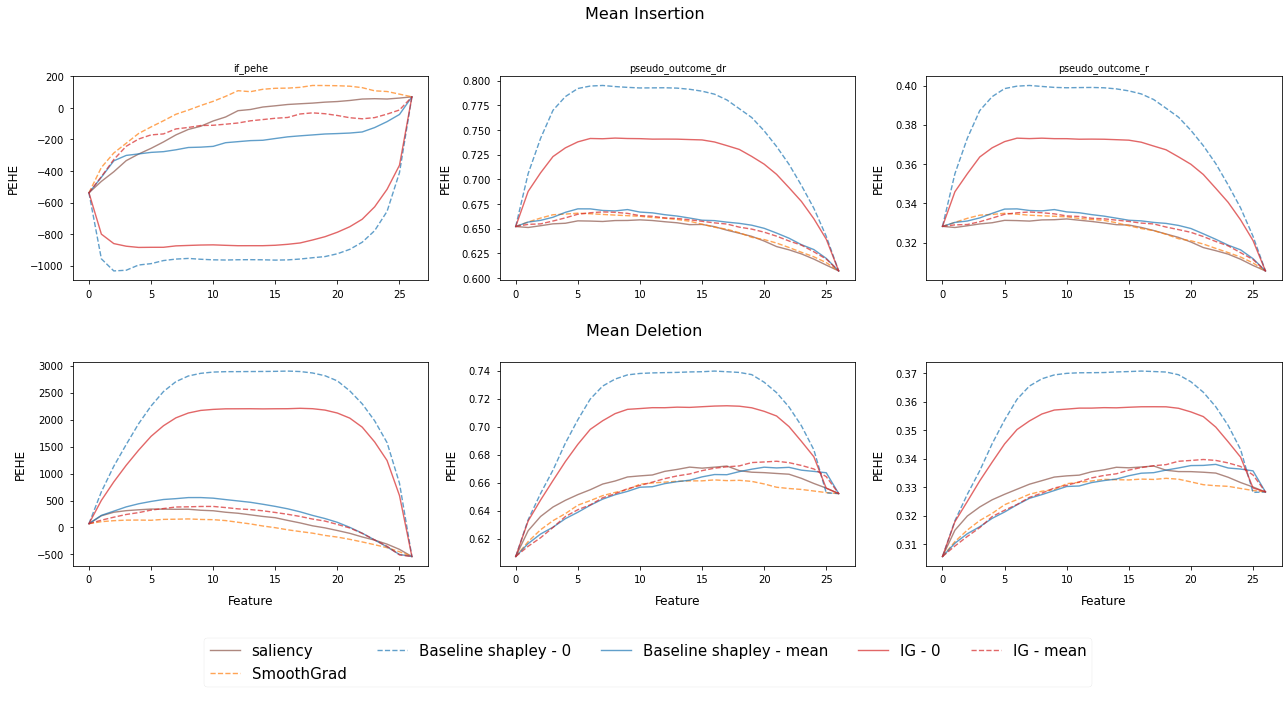

In [36]:
import pickle as pkl
import matplotlib.gridspec as gridspec

# Improved color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Enhanced plot with better readability and visual appeal
plt.style.use('seaborn-paper')

learner = "XLearner"
shuffle = "False"

explainers = [
    "saliency",
    "smooth_grad",
    # "gradient_shap",
    # "lime",
    # "baseline_lime",
    "baseline_shapley_value_sampling",
    "marginal_shapley_value_sampling",
    "integrated_gradients",
    "baseline_integrated_gradients",
    # "kernel_shap"
    # "marginal_shap"
]

selection_types = [ 
    "if_pehe",
    "pseudo_outcome_dr", 
    "pseudo_outcome_r"
]



# Initialize dictionaries to store all results
insertion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}
deletion_results_all = {exp: {sel: [] for sel in selection_types} for exp in explainers}

train_score = {exp: [] for exp in explainers}
test_score = {exp: [] for exp in explainers}
mse = {exp: [] for exp in explainers}

test_score_full = []
train_score_full = []

random_score = []
random_mse = []
# Loop over the different files

seeds = [i for i in range(5)]

for i, file_num in enumerate(seeds):  # assuming there are 5 files, from 0 to 4
    
    # if file_num not in [1]:

    for selection_type in selection_types:
        file_path = f"results/accord/insertion_deletion_shuffle_{shuffle}_{learner}_zero_baseline_True_seed_{file_num}.pkl"
        results = pkl.load(open(file_path,'rb'))

        for exp_index, exp in enumerate(explainers):
            insertion_results_all[exp][selection_type].append((results[exp_index][2][selection_type]))
            deletion_results_all[exp][selection_type].append((results[exp_index][3][selection_type]))
            
            train_score[exp].append(results[exp_index][4])
            test_score[exp].append(results[exp_index][5])
            mse[exp].append(results[exp_index][6])
            
            random_score.append(results[exp_index][8])
            random_mse.append(results[exp_index][9])
                        
            train_score_full.append(results[exp_index][10])
            test_score_full.append(results[exp_index][11])

# Create a grid for subplots
gs = gridspec.GridSpec(2, len(selection_types))

# Create figure
fig = plt.figure(figsize=(6 * len(selection_types), 10))

# To keep track of labels and lines for the legend
handles, labels = [], []

# Calculate and plot mean results
for i, selection_type in enumerate(selection_types):
    for exp in explainers:
        if exp == "baseline_shapley_value_sampling":
            label = "Baseline shapley - 0"
            color = colors[0]
            symbol = "--"
            
        elif exp == "marginal_shapley_value_sampling":
            label = "Baseline shapley - mean"
            color = colors[0]
            symbol = "-"
            
        elif exp == "smooth_grad":
            label = "SmoothGrad"
            color = colors[1]
            symbol = "--"
            
        elif exp == "lime":
            label = "Lime"
            color = colors[2]
            symbol = "--"

        elif exp == "baseline_lime":
            label = "Lime - mean"
            color = colors[2]
            symbol = "-"
            
        elif exp == "integrated_gradients":
            label = "IG - 0"
            color = colors[3]
            symbol = "-"

        elif exp == "baseline_integrated_gradients":
            label = "IG - mean"
            color = colors[3]
            symbol = "--"

        elif exp == "gradient_shap":
            label = "GradientShap"
            color = colors[4]
            symbol = "--"

        else:
            label = exp
            color = colors[5]
            symbol = "-"

        insertion_results_mean = np.mean(insertion_results_all[exp][selection_type], axis=0)
        deletion_results_mean = np.mean(deletion_results_all[exp][selection_type], axis=0)
        features_num = len(insertion_results_mean)

        
        insertion_results_std = np.std(insertion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))
        deletion_results_std = np.std(deletion_results_all[exp][selection_type], axis=0)/np.sqrt(len(seeds))

        # Insertion subplot
        ax1 = plt.subplot(gs[0, i])
        ax1.set_title(f"{selection_type}")
        ax1.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax1.tick_params(axis='both', which='major', labelsize=10)

        # Plot and store the line and label for legend
        line, = ax1.plot(range(features_num), insertion_results_mean, alpha=0.7, color = color, linestyle=symbol, markersize=3)
        # ax1.fill_between(range(features_num), insertion_results_mean - insertion_results_std, insertion_results_mean + insertion_results_std, alpha=0.2)

        # Deletion subplot
        ax2 = plt.subplot(gs[1, i])
        ax2.set_ylabel('PEHE', fontsize=12, labelpad=10)
        ax2.plot(range(features_num), deletion_results_mean,alpha=0.7,  color = color, linestyle = symbol, markersize=3)
        # ax2.fill_between(range(features_num), deletion_results_mean - deletion_results_std, deletion_results_mean + deletion_results_std, alpha=0.2)
        ax2.tick_params(axis='both', which='major', labelsize=10)

        # Add the line handle and label only if it doesn't exist
        if label not in labels:
            handles.append(line)
            labels.append(label)

# Set the x-label for only the bottom subplots
for i in range(len(selection_types)):
    ax = plt.subplot(gs[1, i])
    ax.set_xlabel('Feature', fontsize=12, labelpad=10)

# Set main titles for each row, outside of loops, and adjust positions
fig.text(0.5, 0.96, "Mean Insertion", ha='center', fontsize=16)
fig.text(0.5, 0.52, "Mean Deletion", ha='center', fontsize=16)

# Add a single legend for the entire figure with larger font size
# Move legend below the second row
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), fontsize=15, ncol=5)

# Adjust layout and add more space for the main titles
plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.4, bottom=0.2)
plt.show()

fig.savefig('ins_del_accord.png', dpi=fig.dpi)

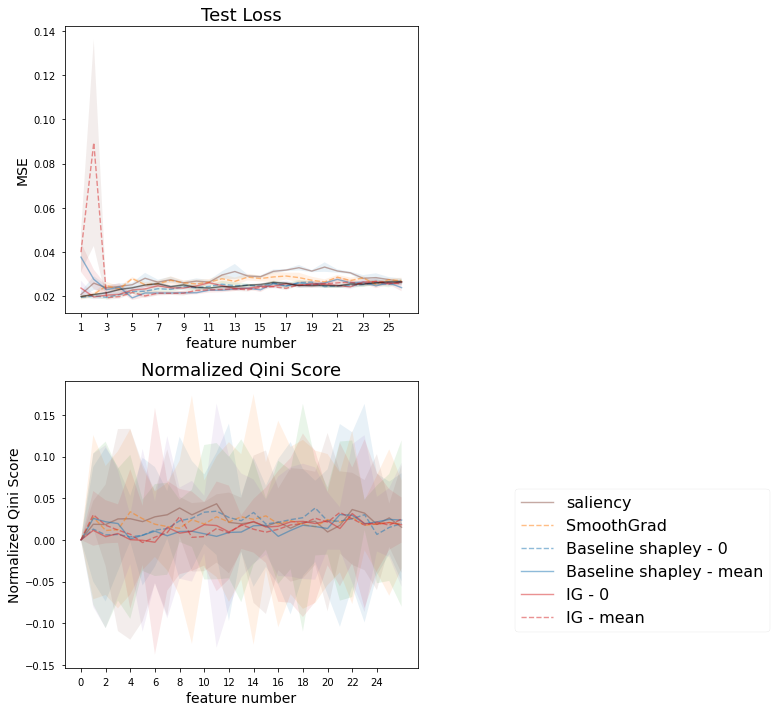

In [45]:
train_results = {exp: np.divide(np.array(result), np.mean(train_score_full)).mean(axis=0) for exp, result in train_score.items()}
train_std  = {exp: np.divide(np.array(result), np.mean(train_score_full)).std(axis=0) for exp, result in train_score.items()}

test_results  = {exp: np.array(result).mean(axis=0) for exp, result in test_score.items()}
test_std  = {exp: np.array(result).std(axis=0) for exp, result in test_score.items()}

mse_results  = {exp: np.array(result).mean(0) for exp, result in mse.items()}
mse_std  = {exp: np.array(result).std(0) for exp, result in mse.items()}


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,10))

# # Plot ATE results
# for k, v in ate_results.items():
#     feature_num = np.arange(v.shape[0] + 1)
#     ax1.plot(feature_num, np.insert(v, 0, 0), label=k)
#     ax1.fill_between(
#         feature_num,
#         np.insert(v, 0, 0) + np.insert(ate_std[k], 0, 0),
#         np.insert(v, 0, 0) - np.insert(ate_std[k], 0, 0),
#         alpha=0.1
#     )

# ax1.set_xticks(range(0, 16, 5))
# ax1.set_xlabel("feature number", size =14)
# ax1.set_ylabel("Subgroup Utility", size =14)
# ax1.set_title("Subgroup Identification (Subgroup Utility)",  size =17)

plt.style.use('seaborn-paper')

# Plot MSE results

for exp, v in mse_results.items():
    feature_num = np.arange(v.shape[0])
    feature_num = feature_num + 1
    
    if exp == "baseline_shapley_value_sampling":
        label = "Baseline shapley - 0"
        color = colors[0]
        symbol = "--"

    elif exp == "marginal_shapley_value_sampling":
        label = "Baseline shapley - mean"
        color = colors[0]
        symbol = "-"

    elif exp == "smooth_grad":
        label = "SmoothGrad"
        color = colors[1]
        symbol = "--"

    elif exp == "lime":
        label = "Lime - 0"
        color = colors[2]
        symbol = "--"

    elif exp == "baseline_lime":
        label = "Lime - mean"
        color = colors[2]
        symbol = "-"

    elif exp == "integrated_gradients":
        label = "IG - 0"
        color = colors[3]
        symbol = "-"

    elif exp == "baseline_integrated_gradients":
        label = "IG - mean"
        color = colors[3]
        symbol = "--"

    elif exp == "gradient_shap":
        label = "GradientShap"
        color = colors[4]
        symbol = "--"

    else:
        label = exp
        color = colors[5]
        symbol = "-"

    ax1.plot(feature_num, v, label=label, color = color, alpha=0.5, linestyle = symbol)
    
    ax1.fill_between(
        feature_num,
        v + mse_std[exp]/np.sqrt(len(mse_std)),
        v - mse_std[exp]/np.sqrt(len(mse_std)),
        alpha=0.1
    )
    
rand_std = np.std(random_mse, axis=0)/np.sqrt(20)
rand_mse = np.mean(random_mse, axis=0)

ax1.plot(feature_num, rand_mse, color = "black", label="random",alpha=0.5)
ax1.fill_between(
    feature_num,
    rand_mse + rand_std,
    rand_mse - rand_std,
    alpha=0.1,
    color = "black"
)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.set_xticks(range(1,  x.shape[1], 2))
ax1.set_xlabel("feature number", size =14)
ax1.set_ylabel("MSE", size = 14)
ax1.set_title("Test Loss", size =18)


# Plot AUROC results
for exp, v in test_results.items():
    feature_num = np.arange(v.shape[0] + 1)
    
    if exp == "baseline_shapley_value_sampling":
        label = "Baseline shapley - 0"
        color = colors[0]
        symbol = "--"

    elif exp == "marginal_shapley_value_sampling":
        label = "Baseline shapley - mean"
        color = colors[0]
        symbol = "-"

    elif exp == "smooth_grad":
        label = "SmoothGrad"
        color = colors[1]
        symbol = "--"

    elif exp == "lime":
        label = "Lime - 0"
        color = colors[2]
        symbol = "--"

    elif exp == "baseline_lime":
        label = "Lime - mean"
        color = colors[2]
        symbol = "-"

    elif exp == "integrated_gradients":
        label = "IG - 0"
        color = colors[3]
        symbol = "-"

    elif exp == "baseline_integrated_gradients":
        label = "IG - mean"
        color = colors[3]
        symbol = "--"

    elif exp == "gradient_shap":
        label = "GradientShap"
        color = colors[4]
        symbol = "--"

    else:
        label = exp
        color = colors[5]
        symbol = "-"
        
    ax2.plot(feature_num, np.insert(v, 0, 0), color = color,alpha=0.5, linestyle= symbol, label=label)
    ax2.fill_between(
        feature_num,
        np.insert(v, 0, 0)+ np.insert(train_std[exp]/np.sqrt(5), 0, 0),
        np.insert(v, 0, 0)- np.insert(train_std[exp]/np.sqrt(5), 0, 0),
        alpha=0.1
    )

    
rand_std = np.insert(np.std(random_score/(np.mean(train_score_full)), axis=0)/np.sqrt(20), 0,0)
rand_score = np.insert(np.mean(random_score, axis=0)/(np.mean(train_score_full)), 0, 0)

# ax2.hlines(y=1.0, xmin=0, xmax=np.max(feature_num), color='black', linestyle='--', label="Teacher model with all features")

# ax2.plot(feature_num, rand_score, color = "black", label="random",alpha=0.5)
# ax2.fill_between(
#     feature_num,
#     rand_score + rand_std,
#     rand_score - rand_std,
#     alpha=0.1,
#     color = "black"
# )

ax2.tick_params(axis='both', which='major', labelsize=10)

ax2.set_xticks(range(0, x.shape[1], 2))
ax2.set_xlabel("feature number", size =14)
ax2.set_ylabel("Normalized Qini Score",  size =14)
ax2.set_title("Normalized Qini Score",  size =18)

# Adjust legend location
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right',prop={'size': 16}, bbox_to_anchor=(1.8, 0.1))

plt.tight_layout()
plt.show()

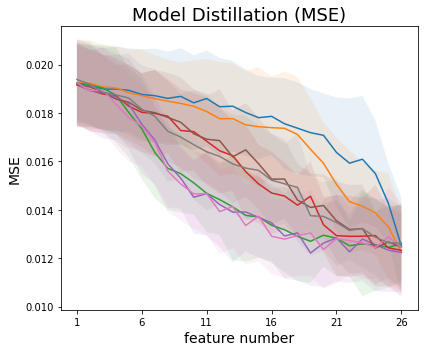

In [189]:
mse_results  = {exp: np.array(result).mean(0) for exp, result in mse.items()}
msec_std  = {exp: np.array(result).std(0) for exp, result in mse.items()}

plt.figure(figsize=(6,5))

# Plot MSE results
for k, v in mse_results.items():
    feature_num = np.arange(v.shape[0])
    feature_num = feature_num+1
    plt.plot(feature_num, v, label=k)
    
    plt.fill_between(
        feature_num,
        v + msec_std[k],
        v - msec_std[k],
        alpha=0.1
    )

plt.xticks(range(1, 27, 5))
plt.xlabel("feature number", size =14)
plt.ylabel("MSE", size = 14)
plt.title("Model Distillation (MSE)", size =18)

# plt.legend(loc='center right')

plt.tight_layout()
plt.show()